In [6]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [8]:
def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def r2(y_train, y, y_hat):
    sse = np.sum((y - y_hat)**2)
    sst = np.sum((y - y_train.mean())**2)
    return 1 - sse/sst

In [9]:
def geo_difference(df):
    df = df.copy()
    countries = ["FRA", "NLD", "GBR", "DEU"]
    
    n_cols = []
    for s_col in df.columns:
        s_cty = s_col[s_col.find("-")+1:s_col.find("-")+4]
        for a_cty in countries:
            if a_cty != s_cty:
                a_col = s_col.replace(s_cty, a_cty)
                if a_col in df.columns:
                    n_cols.append(pd.Series(np.subtract(df[s_col],df[a_col]), name=s_col+"_minus_"+a_col))
    df = pd.concat([df] + n_cols, axis=1)
    df = df.T.drop_duplicates().T
    for c1 in df.columns.values:
        for c2 in df.columns:
            if c1!=c2:
                if all(df[c1] == -df[c2]):
                        df = df.drop(c1, axis=1)
                        break
    return df

In [10]:
cols_to_drop = ["model_0_value-NLD_WIND_GEFS-24",
    "model_0_value-NLD_WIND_GEFS-48",
    "model_0_value-NLD_WIND_GEFS-72",
    "ens_std-NLD_WIND_GEFS-24",
    "ens_std-NLD_WIND_GEFS-48",
    "ens_std-NLD_WIND_GEFS-72",
    "model_0_value-FRA_WIND_GEFS-24",
    "model_0_value-FRA_WIND_GEFS-48",
    "model_0_value-FRA_WIND_GEFS-72",
    'ens_std-FRA_WIND_GEFS-24',
    "ens_std-FRA_WIND_GEFS-48",
    "ens_std-FRA_WIND_GEFS-72"]

In [11]:
def get_data(cols_to_drop, model="EC15"):
    df_train = pd.read_hdf('../data/'+model+'_split.h5', key="train")
    df_valid = pd.read_hdf('../data/'+model+'_split.h5', key="validation")
    df_test = pd.read_hdf('../data/'+model+'_split.h5', key="test")
    if model=="GEFS":
        df_train = df_train.drop(cols_to_drop, axis=1).dropna(axis=0)
        df_valid = df_valid.drop(cols_to_drop, axis=1).dropna(axis=0)
        df_test = df_test.drop(cols_to_drop, axis=1).dropna(axis=0)
    df_train_dif = geo_difference(df_train)
    df_val_dif = geo_difference(df_valid)
    df_test_dif = geo_difference(df_test)
    # return df_train, df_valid, df_test
    return df_train_dif, df_val_dif, df_test_dif

def get_target_data(df_train_dif, df_val_dif, df_test_dif, target, t):
    y_train = df_train_dif[target].shift(-t)[0:len(df_train_dif)-t]
    y_valid = df_val_dif[target].shift(-t)[0:len(df_val_dif)-t]
    y_test = df_test_dif[target].shift(-t)[0:len(df_test_dif)-t]
    df_train_dif = df_train_dif[0:len(df_train_dif)-t].drop([target], axis=1)
    df_val_dif = df_val_dif[0:len(df_val_dif)-t].drop([target], axis=1)
    df_test_dif = df_test_dif[0:len(df_test_dif)-t].drop([target], axis=1)
    return df_train_dif, df_val_dif, df_test_dif, y_train, y_valid, y_test

In [12]:
def subset_selection(k, selection_method, X_train, y_train):
    X_subset = SelectKBest(selection_method, k=k).fit_transform(X_train, y_train)
    cols = []
    for i in range(len(X_subset[0,:])):
        for col in X_train.columns:
            if X_subset[0,i] in X_train[col].unique():
                if col not in cols:
                    cols.append(col)
    return cols

In [13]:
def train(X, y):
    reg = LinearRegression().fit(X, y)
    return reg

def train_err(X, y):
    reg = LinearRegression().fit(np.array(X).reshape(-1,1), np.array(y).reshape(-1,1))
    return reg


def predict(model, error_model, X):
    y_hat = model.predict(X)
    y_hat_err = error_model.predict(np.array(y_hat).reshape(-1,1))
    return y_hat + y_hat_err.reshape(len(y_hat_err),)

In [14]:
def forecast(X_train, X_new, y_train,  k, selection_method, target):
    cols = subset_selection(k, selection_method, X_train, y_train)
    print("Target: ", target)
    print("Chosen columns: ", cols)
    X_train = X_train[cols]
    X_new = X_new[cols]
    model = train(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_new)
    error_model = train(np.array(y_train).reshape(-1,1), np.array(y_train-pred_train).reshape(-1,1))
    y_hat_train = predict(model, error_model, X_train)
    y_hat_valid = predict(model, error_model, X_new)
    return y_hat_train, y_hat_valid, pred_train, pred_valid

In [15]:
def evaluate(y_train, y_valid, y_hat_train, y_hat_valid, y_hat_train_no_err, y_hat_valid_no_err):
    print("Train MSE: ", mse(y_train, y_hat_train))
    print("Train MSE (no error correction): ", mse(y_train, y_hat_train_no_err))
    print("Validation MSE: ", mse(y_valid, y_hat_valid))
    print("Validation MSE (no error correction): ", mse(y_valid, y_hat_valid_no_err))
    print("Train R2: ", r2(y_train, y_train, y_hat_train))
    print("Train R2 (no error correction): ", r2(y_train, y_train, y_hat_train_no_err))
    print("Validation R2: ", r2(y_train, y_valid, y_hat_valid))
    print("Validation R2 (no error correction): ", r2(y_train, y_valid, y_hat_valid_no_err))

In [27]:
def plot_forecast(y_hat_train, y_hat_valid, y_hat_train_no_err, y_hat_valid_no_err, y_train, y_valid):
    plt.figure(figsize=(20,10))
    plt.plot(df_train_dif.index[0:len(df_train_dif)-4], y_train, label="Train")
    plt.plot(df_train_dif.index[0:len(df_train_dif)-4], y_hat_train, label="Train Forecast")
    plt.plot(df_train_dif.index[0:len(df_train_dif)-4], y_hat_train_no_err, label="Train Forecast (no error correction)")
    plt.plot(df_val_dif.index[0:len(df_val_dif)-4], y_valid, label="Validation")
    plt.plot(df_val_dif.index[0:len(df_val_dif)-4], y_hat_valid, label="Validation Forecast")
    plt.plot(df_val_dif.index[0:len(df_val_dif)-4], y_hat_valid_no_err, label="Validation Forecast (no error correction)")
    plt.legend()
    plt.show()

    plt.scatter(x=y_valid, y=y_valid-y_hat_valid)
    plt.scatter(x=y_valid, y=y_valid-y_hat_valid_no_err)
#     plt.figure(figsize=(20,10))
#     plt.plot(df_train_dif.index[0:len(df_train_dif)-2], y_train, label="Train")
#     plt.plot(df_train_dif.index[0:len(df_train_dif)-2], y_hat_train, label="Train Forecast")
#     plt.plot(df_train_dif.index[0:len(df_train_dif)-2], y_hat_train_no_err, label="Train Forecast (no error correction)")

In [17]:
targets_GEFS = [
    "ens_std-GBR_WIND_GEFS-24","ens_std-GBR_TEMP_GEFS-24",
     "ens_std-FRA_TEMP_GEFS-24", 
    "ens_std-DEU_WIND_GEFS-24", "ens_std-DEU_TEMP_GEFS-24", 
     "ens_std-NLD_TEMP_GEFS-24", 
    # 'model_0_value-FRA_WIND_EC15-24', 'model_0_value-DEU_WIND_EC15-24', 'model_0_value-FRA_TEMP_EC15-24', 'model_0_value-DEU_TEMP_EC15-24'
]

targets_EC15 = [
    "ens_std-GBR_WIND_EC15-24",
     "ens_std-FRA_WIND_EC15-24", "ens_std-FRA_TEMP_EC15-24",
    "ens_std-DEU_WIND_EC15-24", "ens_std-DEU_TEMP_EC15-24", 
     "ens_std-NLD_WIND_EC15-24", 
    # 'model_0_value-FRA_WIND_EC15-24', 'model_0_value-DEU_WIND_EC15-24', 'model_0_value-FRA_TEMP_EC15-24', 'model_0_value-DEU_TEMP_EC15-24'
]


In [21]:
 df_train = pd.read_hdf('../data/EC15_split.h5', key="train")

In [22]:
df_train_dif, df_val_dif, df_test_dif = get_data(cols_to_drop, "EC15")

In [28]:
preds = []
def forecast_all(targets, k=5, selection_method=f_regression, t=4, testset=False):
    for target in targets:
        df_train, df_valid, df_test, y_train, y_valid, y_test = get_target_data(df_train_dif, df_val_dif, df_test_dif, target, t)
        if not testset:
            y_hat_train, y_hat_valid, y_hat_train_no_err, y_hat_valid_no_err = forecast(df_train, df_valid, y_train, k, selection_method, target)
            evaluate(y_train, y_valid, y_hat_train, y_hat_valid, y_hat_train_no_err, y_hat_valid_no_err)
            # plot_forecast(y_hat_train, y_hat_valid, y_hat_train_no_err, y_hat_valid_no_err, y_train, y_valid)
        else:
            print("Test")
            y_hat_train, y_hat_test, y_hat_train_no_err, y_hat_test_no_err = forecast(df_train, df_test, y_train, k, selection_method, target)
            preds.append(y_hat_test_no_err)
            evaluate(y_train, y_test, y_hat_train, y_hat_test, y_hat_train_no_err, y_hat_test_no_err)
            # plot_forecast(y_hat_train, y_hat_valid, y_hat_train_no_err, y_hat_valid_no_err, y_train, y_valid)
        print()


In [29]:
forecast_all(targets_EC15, testset=False)

Target:  ens_std-GBR_WIND_EC15-24
Chosen columns:  ['ens_std-GBR_WIND_EC15-72', 'ens_std-GBR_WIND_EC15-72_minus_ens_std-FRA_WIND_EC15-72', 'ens_std-DEU_WIND_EC15-72_minus_ens_std-GBR_WIND_EC15-72', 'ens_std-GBR_TEMP_EC15-72_minus_ens_std-FRA_TEMP_EC15-72', 'ens_std-DEU_TEMP_EC15-72_minus_ens_std-GBR_TEMP_EC15-72']
Train MSE:  0.013586147669616976
Train MSE (no error correction):  0.011327863237194452
Validation MSE:  0.017122576840715158
Validation MSE (no error correction):  0.013655136373792957
Train R2:  0.1304174517318969
Train R2 (no error correction):  0.27495914075326233
Validation R2:  0.024343156487095285
Validation R2 (no error correction):  0.2219204284419718

Target:  ens_std-FRA_WIND_EC15-24
Chosen columns:  ['model_0_value-FRA_WIND_EC15-72', 'ens_std-FRA_WIND_EC15-48', 'ens_std-FRA_WIND_EC15-72', 'ens_std-NLD_WIND_EC15-72', 'ens_std-DEU_WIND_EC15-72']
Train MSE:  0.0045815986586507955
Train MSE (no error correction):  0.0036784288015613686
Validation MSE:  0.0043358460631

Target:  ens_std-FRA_TEMP_EC15-24
Chosen columns:  ['ens_std-FRA_TEMP_EC15-48', 'ens_std-DEU_TEMP_EC15-48', 'ens_std-DEU_TEMP_EC15-72', 'ens_std-GBR_TEMP_EC15-48_minus_ens_std-FRA_TEMP_EC15-48', 'ens_std-DEU_TEMP_EC15-48_minus_ens_std-FRA_TEMP_EC15-48']
Train MSE:  0.011849027719589495
Train MSE (no error correction):  0.009483365246497939
Validation MSE:  0.011627522209853256
Validation MSE (no error correction):  0.009250940478282623
Train R2:  0.3460749087008892
Train R2 (no error correction):  0.4766312788359477
Validation R2:  0.3057401705007623
Validation R2 (no error correction):  0.4476418756080657


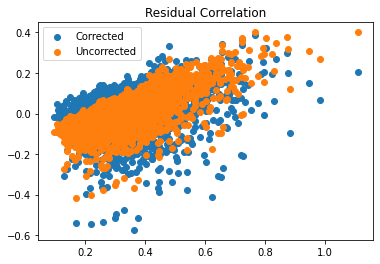

In [31]:
k=5
selection_method=f_regression
t=2
target="ens_std-FRA_TEMP_EC15-24"
df_train, df_valid, df_test, y_train, y_valid, y_test = get_target_data(df_train_dif, df_val_dif, df_test_dif, target, t)
y_hat_train, y_hat_valid, y_hat_train_no_err, y_hat_valid_no_err = forecast(df_train, df_valid, y_train, k, selection_method, target)
evaluate(y_train, y_valid, y_hat_train, y_hat_valid, y_hat_train_no_err, y_hat_valid_no_err)
plt.scatter(x=y_valid, y=y_valid-y_hat_valid, label="Corrected")
plt.scatter(x=y_valid, y=y_valid-y_hat_valid_no_err, label="Uncorrected")
plt.rcParams["figure.figsize"] = (10,10)
plt.title("Residual Correlation")
plt.legend()

# plot_forecast(y_hat_train, y_hat_test, y_hat_train_no_err, y_hat_test_no_err, y_train, y_test)

In [32]:
baseline = df_val_dif["ens_std-DEU_TEMP_EC15-48"].values[0:len(df_val_dif)-2]
index = df_val_dif.index[0:len(df_val_dif)-2]

In [33]:
var_valid = pd.read_csv("../data/DEU_TEMP_t+24.csv")
lgbm_valid = pd.read_csv("../data/lgb_DEU_TEMP_EC15_valid_pred.csv")
sr_valid = y_hat_valid 

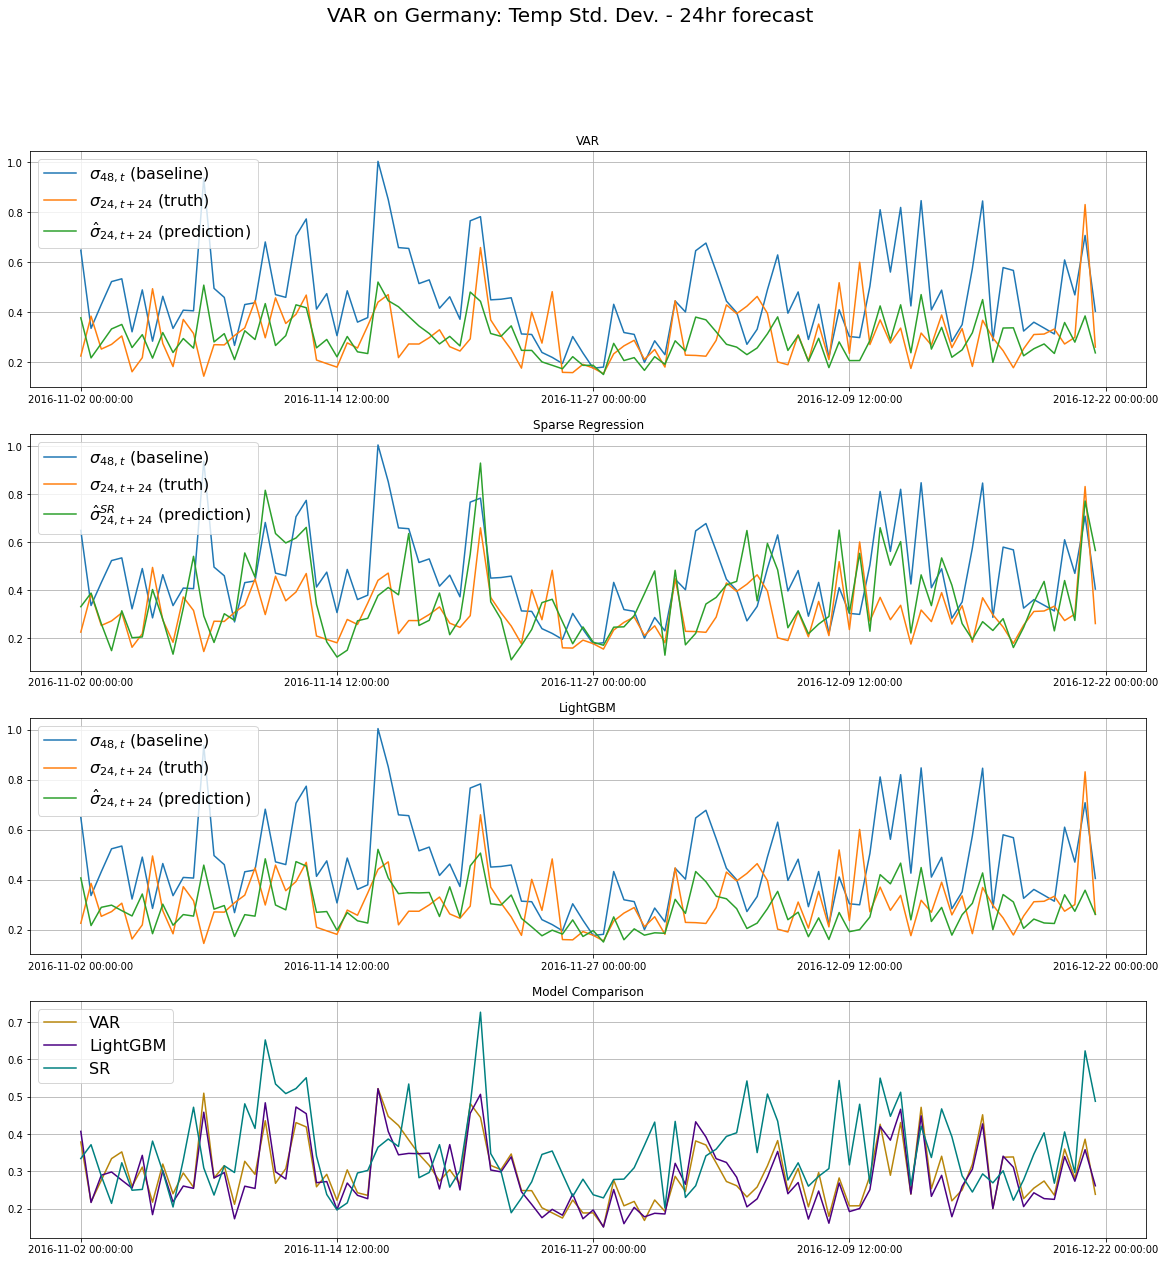

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(20,20))

ax1.plot(index[100:200], baseline[100:200], label="$σ_{{48},{t}}$ (baseline)")
ax1.plot(index[100:200], y_valid[100:200], label="$σ_{{24},{t+24}}$ (truth)")
ax1.plot(index[100:200], var_valid["0"][100:200], label="$\hat{σ}_{{24},{t+24}}$ (prediction)")
ax1.set_xticks(index[[100,125,150,175,200]])
ax1.set_title("VAR")
ax1.grid()

ax2.plot(index[100:200], baseline[100:200], label="$σ_{{48},{t}}$ (baseline)")
ax2.plot(index[100:200], y_valid[100:200], label="$σ_{{24},{t+24}}$ (truth)")
ax2.plot(index[100:200], y_hat_valid[100:200], label="$\hat{σ}^{SR}_{{24},{t+24}}$ (prediction)")
ax2.set_xticks(index[[100,125,150,175,200]])
ax2.set_title("Sparse Regression")
ax2.grid()

ax3.plot(index[100:200], baseline[100:200], label="$σ_{{48},{t}}$ (baseline)")
ax3.plot(index[100:200], y_valid[100:200], label="$σ_{{24},{t+24}}$ (truth)")
ax3.plot(index[100:200], lgbm_valid['y_hat'][100:200], label="$\hat{σ}_{{24},{t+24}}$ (prediction)")
ax3.set_xticks(index[[100,125,150,175,200]])
ax3.set_title("LightGBM")
ax3.grid()

ax4.plot(index[100:200], var_valid["0"][100:200], label="VAR", color="darkgoldenrod")
ax4.plot(index[100:200], lgbm_valid['y_hat'][100:200], label="LightGBM", color="indigo")
ax4.plot(index[100:200], y_hat_valid_no_err[100:200], label="SR", color="teal")
# ax4.plot(index[100:200], y_hat_valid_no_err[100:200], label="SR", color="maroon")
ax4.set_xticks(index[[100,125,150,175,200]])
ax4.set_title("Model Comparison")
ax4.grid()

fig.suptitle("VAR on Germany: Temp Std. Dev. - 24hr forecast", fontsize = 20)
ax1.legend(prop={'size': 16})
ax2.legend(prop={'size': 16})
ax3.legend(prop={'size': 16})
ax4.legend(prop={'size': 16})
plt.show()

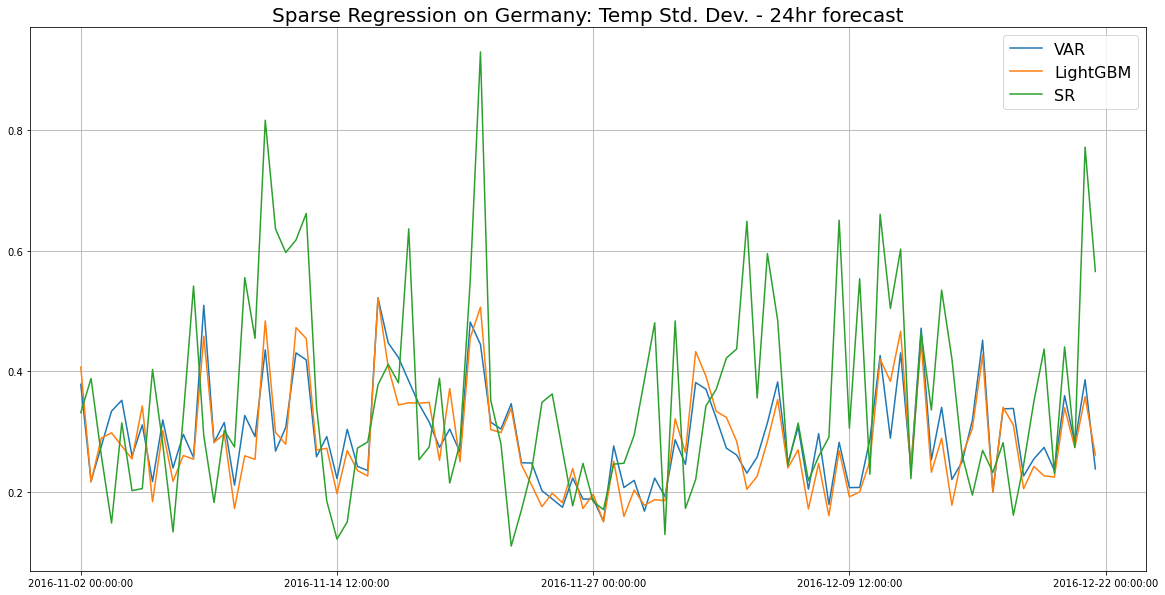

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(index[100:200], var_valid["0"][100:200], label="VAR")
ax.plot(index[100:200], lgbm_valid['y_hat'][100:200], label="LightGBM")
ax.plot(index[100:200], y_hat_valid[100:200], label="SR")
ax.set_xticks(index[[100,125,150,175,200]])
ax.grid()
plt.title("Sparse Regression on Germany: Temp Std. Dev. - 24hr forecast", fontsize = 20)
plt.legend(prop={'size': 16})
plt.show()

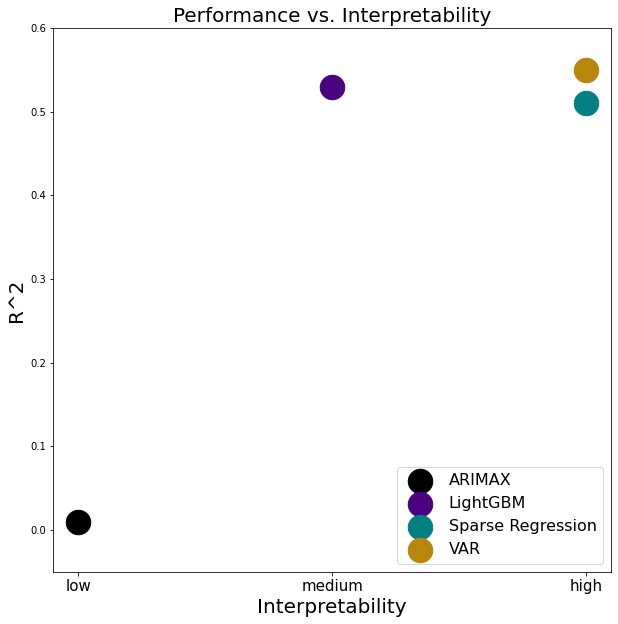

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter([1], [0.01], s=600, c=["black"], label="ARIMAX")
ax.scatter([2], [0.53], s=600, c=["indigo",], label="LightGBM")
ax.scatter([3], [0.51], s=600, c=["teal"], label="Sparse Regression")
ax.scatter([3], [0.55], s=600, c=["darkgoldenrod"], label="VAR")
ax.set_xticks([1,2,3])
ax.set_ylabel("R^2", fontsize = 20)
ax.set_xlabel("Interpretability", fontsize = 20)
ax.set_ylim(-0.05,0.6)
ax.set_xticklabels(["low","medium","high"], fontsize = 15)
plt.title("Performance vs. Interpretability", fontsize = 20)
plt.legend(prop={'size': 16}, loc='lower right')
plt.show()